# Multiple Variate Forecasting Using Regression Models

We have used two ways to predict multiple spare parts demands at the same time using regression models.

1. Individual Models : Trained seperate model for each spare part on data related to itself.

2. One Model for Everything : Trained one model for all the spare parts on complete data.

Importing some basic tools.

In [3]:
# Render our plots inline
%matplotlib inline

# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir("C:/Users/shubham.gupta1/Downloads/hilti/input_data") # change the path with your data directory

# Aggregating the Data

Steps that we followed for preparing the final_data.csv :

1. Selected all task1 data from notifications.csv
2. Grouped task1 data based on year, material and week and aggregated the no. of repairs from it.
3. Added rows for all the missing weeks for every spare parts. So now we have one data row for each part, for each week starting from 1st week of 2015.
4. Collected weather data with features like pressure, min temp, max temp, humidity and wind speed and grouped it weekwise.
5. Collected holidays data and grouped it week wise.
6. Did feature engineering and created new features with lag data for each spare part for past 4 weeks.
7. Merged all these datasets into single dataframe to form week wise data for each and every spare part.

In [4]:
df_init = pd.read_csv('final_data.csv')

In [27]:
df_init[:5]

,spare,year,week,pressure,min_temp,wind_speed,max_temp,humidity,holidays,repairs,last_week_repairs,last_week_diff,last_minus_one_week_repairs,last_minus_one_week_diff,last_minus_two_week_repairs,last_minus_two_week_diff,last_minus_three_week_repairs,last_minus_three_week_diff
0,74473,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74476,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,74873,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,206121,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,206145,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16185 entries, 0 to 16184
Data columns (total 18 columns):
spare                            16185 non-null int64
year                             16185 non-null int64
week                             16185 non-null int64
pressure                         16185 non-null float64
min_temp                         16185 non-null float64
wind_speed                       16185 non-null float64
max_temp                         16185 non-null float64
humidity                         16185 non-null float64
holidays                         16185 non-null float64
repairs                          16185 non-null int64
last_week_repairs                16102 non-null float64
last_week_diff                   16019 non-null float64
last_minus_one_week_repairs      16019 non-null float64
last_minus_one_week_diff         15936 non-null float64
last_minus_two_week_repairs      15936 non-null float64
last_minus_two_week_diff         15853 non-null float64
las

# Accuracy Metrics

We have used 3 metrics here.
1. RMSE : It is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are.

2. Penalized RMSE : This is the custom rmse that we have used to penalize the negative errors.

3. RMSLE : It is used for comparing results when we create sepearete models for each spare part. As RMSE depends on the range of the variable on which it is performed, it cannot be used to compare between two models, where target variable have significant difference in their ranges. But RMSLE is independent of the range of the target variable. It can be considered the approximate percentage error.

Note : We cannot use MAPE here as our values have zero in it, and MAPE is not capable of dealing zeroes.

In [84]:
# Basic accuracy metrics function : Provides metrics like RMSE, RMSLE, MAE, EVS, R2_Score

def accuracy_matrices(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import r2_score
    from math import sqrt
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    rmsle = sqrt(mean_squared_log_error(y_true, y_pred))
    mae = sqrt(mean_absolute_error(y_true, y_pred))
    evs = explained_variance_score(y_true, y_pred)
    R2_score = r2_score(y_true, y_pred)
    return rmse


# penalized rmse function

def penalized_rmse(targets, predictions):
    n = len(predictions)
    underPredictionPenalize =10
    overPredictionPenalize =1
    error =0
    under_predict = 0
    over_predict = 0
    for i in range(n):
        predictedValue =predictions[i]
        actualValue = targets[i]
        if(predictedValue < actualValue):
            under_predict += 1
            error += (underPredictionPenalize*(actualValue - predictedValue))**2
        elif(predictedValue >= actualValue):
            over_predict += 1
            error +=(overPredictionPenalize* (actualValue - predictedValue))**2
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    import numpy as np
    return np.sqrt(error/n), under_predict, over_predict

# 1.1 Building Individual Models

Initially, we trained various models like Linear Regression, SVM, Random Forest, etc. And we got promising results with LightGBM. We have used this model before in various kaggle competitions and have seen that it's very common to have the best results with this type of model, which is an ensemble of trees like a Random Forest, but the method that it uses to create and combine the trees is different.

There are many parameters we can tune for this model but we have simply put 600 trees with default values for all other parameters. We will try to improve the predictions using Hyperparameter tunning if time permits.

Here we have trained 83 lightGBM models for 83 different spare parts seperatly in a loop.

In [24]:
df1 = df_init.copy()

In [4]:
df1[:5]

,spare,year,week,pressure,min_temp,wind_speed,max_temp,humidity,holidays,repairs,last_week_repairs,last_week_diff,last_minus_one_week_repairs,last_minus_one_week_diff,last_minus_two_week_repairs,last_minus_two_week_diff,last_minus_three_week_repairs,last_minus_three_week_diff
0,74473,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74476,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,74873,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,206121,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,206145,2015,1,1018.145,33.45,1.3375,38.99,0.91,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# Grouping data spare wise
spare_groups = df1.groupby(['spare'])
spare_groups.get_group(74473)[:5]

,spare,year,week,pressure,min_temp,wind_speed,max_temp,humidity,holidays,repairs,last_week_repairs,last_week_diff,last_minus_one_week_repairs,last_minus_one_week_diff,last_minus_two_week_repairs,last_minus_two_week_diff,last_minus_three_week_repairs,last_minus_three_week_diff
0,74473,2015,1,1018.145000,33.45,1.337500,38.99,0.910000,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,74473,2015,2,1018.425714,28.70,1.507143,57.16,0.871429,1.0,19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,74473,2015,3,1018.728571,28.83,2.422857,51.07,0.837143,0.0,23,19.0,18.0,1.0,NaN,NaN,NaN,NaN,NaN
249,74473,2015,4,1018.937143,22.84,0.938571,36.71,0.880000,0.0,29,23.0,4.0,19.0,18.0,1.0,NaN,NaN,NaN
332,74473,2015,5,1019.007143,29.19,1.504286,39.17,0.901429,0.0,22,29.0,6.0,23.0,4.0,19.0,18.0,1.0,NaN


In [65]:
all_pred = pd.DataFrame([[0,123,321, 11],[0,1543,432, 11]], columns=['spare','week', 'repairs', 'y_pred'])

In [66]:
all_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
spare      2 non-null int64
week       2 non-null int64
repairs    2 non-null int64
y_pred     2 non-null int64
dtypes: int64(4)
memory usage: 144.0 bytes


In [86]:
#test dfs from week 25 to week 36 of 2018 (12 weeks). 

import lightgbm as lgb
results = []
fi = []
spares = df1.spare.unique()
# result_col = ['Spare Id','Mean (repairs/week)', 'Min (repairs/week)', 'Max (repairs/week)', 'Rmse','Penalized_Rmse',
#               'Total weeks', 'Under_Predict Weeks', 'Over_Predict Weeks', 'RMSLE', 'MAE', 'Explained Variance', 'R2 Score']
result_col = ['Spare ID', 'Rmse']
for spare in list(spares):
    
    # Creating dataframe of an individual spare
    df_spare = spare_groups.get_group(spare)
    
    # Mean, Min and Max of number of repairs
    mean = df_spare['repairs'].mean()
    min_spare = df_spare['repairs'].min()
    max_spare = df_spare['repairs'].max()
    
    # Test Data Frame consists 12 weeks of data from week 25th to 36th of 2018.
    # Not including week 37 as it has incomplete data.
    test_df = df_spare[-12:]
    
    # Train Data Frame consists of data from 6th week of 2015 to 24th week of 2018.
    # Initial 5 weeks of data was not used as its has null values for 4 week lag data columns.
    train_df = df_spare[6:-12]
    
    x_col = list(set(list(train_df)) - set(['spare', 'repairs']))     # x_col : Features
    
    y_col = ['repairs'] # y_col : Target Variable
    
    train_x = train_df[x_col]
    train_y = train_df[y_col]
    test_x = test_df[x_col]
    test_y = test_df[y_col]
    
    # Converting dataframe to lightGBM library dataset.
    d_train = lgb.Dataset(train_x, label=train_y)
    
    # setting basic parameters
    params = { "objective": "regression", "metric": "rmse"}
    
    # Training the model
    lgbmodel = lgb.train(params, d_train, 600)
    
    # Predicting for test df
    y_pred_lgbm=lgbmodel.predict(test_x)
    
#     temp_df = test_df.copy()
#     temp_df['y_pred'] = y_pred_lgbm
#     temp_df = temp_df[['spare','week', 'repairs', 'y_pred']]
#     all_pred = pd.concat([all_pred, temp_df], ignore_index=True)
    
    # Calculating Accuracy Metrics
    rmse = accuracy_matrices(test_y, y_pred_lgbm)
    
    # Calculating Penalized RMSE
#     penaliz_rmse, under_predict, over_predict = penalized_rmse(test_y.squeeze().tolist(), y_pred_lgbm.squeeze().tolist())
    
    # Saving the metric outcomes.
    results.append([spare, rmse])
    
    # Saving the feature importance values
#     fi.append(list(lgbmodel.feature_importance()))

result_df = pd.DataFrame(results, columns=result_col)
# feat_imp = pd.DataFrame(fi,columns = list(set(list(df1)) - set(['spare', 'repairs'])) )

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [68]:
all_pred = all_pred[2:]
all_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 2 to 997
Data columns (total 4 columns):
spare      996 non-null int64
week       996 non-null int64
repairs    996 non-null int64
y_pred     996 non-null float64
dtypes: float64(1), int64(3)
memory usage: 31.2 KB


In [70]:
all_pred[:15]

,spare,week,repairs,y_pred
2,74473,26,31,31.365737
3,74473,27,30,29.657391
4,74473,28,34,31.404603
5,74473,29,43,32.090226
6,74473,30,35,32.383071
7,74473,31,38,28.259873
8,74473,32,32,30.705383
9,74473,33,23,27.413599
10,74473,34,26,34.587108
11,74473,35,27,26.481921


In [32]:
all_pred.to_csv('type1.csv', index=False)

# 1.2 Evaluating the Models

In [27]:
result_df[:5]

,Spare Id,Mean (repairs/week),Min (repairs/week),Max (repairs/week),Rmse,Penalized_Rmse,Total weeks,Under_Predict Weeks,Over_Predict Weeks,RMSLE,MAE,Explained Variance,R2 Score
0,74473,29.312821,0,51,6.545401,19.179342,12,8,4,0.196458,2.297816,0.184934,0.019347
1,74476,61.010256,0,96,11.460885,22.383772,12,3,9,0.222176,3.180420,-0.076289,-0.219987
2,74873,31.543590,0,67,11.802507,35.065674,12,7,5,0.271473,3.141550,-0.511779,-0.839608
3,206121,165.471795,0,284,28.411678,86.787492,12,10,2,0.122093,4.974509,0.558231,0.237804
4,206145,10.753846,0,28,3.118350,7.827135,12,6,6,0.457120,1.652991,-0.378612,-0.394692


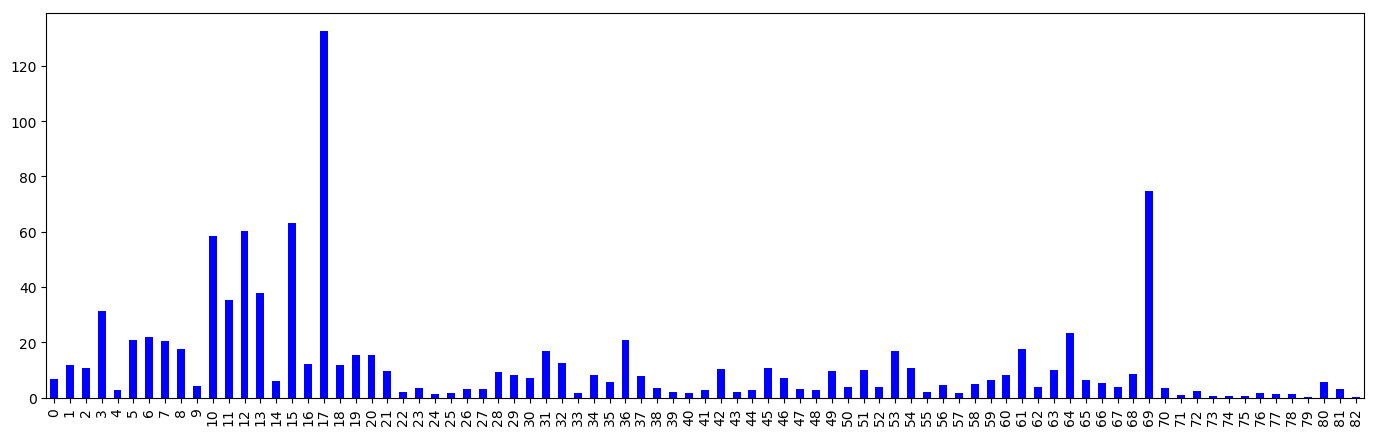

In [68]:
result_df['Rmse'].plot(kind='bar', figsize=(17,5), color='blue')

In [71]:
print('Mean Rmse: ',result_df['Rmse'].mean())
print('Minimum Rmse: ',result_df['Rmse'].min())
print('Maximum Rmse: ',result_df['Rmse'].max())

Mean Rmse:  12.334775665938901
Minimum Rmse:  0.022171790578346007
Maximum Rmse:  132.6990401948596


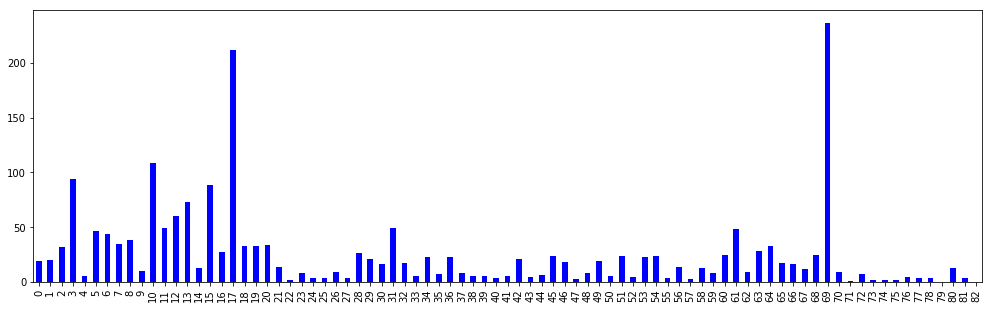

In [19]:
result_df['Penalized_Rmse'].plot(kind='bar', figsize=(17,5), color='blue')

In [70]:
print('Mean Penalized Rmse: ',result_df['Penalized_Rmse'].mean())
print('Minimum Penalized Rmse: ',result_df['Penalized_Rmse'].min())
print('Maximum Penalized Rmse: ',result_df['Penalized_Rmse'].max())

Mean Penalized Rmse:  24.892526827513453
Minimum Penalized Rmse:  0.022171790578346007
Maximum Penalized Rmse:  236.0936707798064


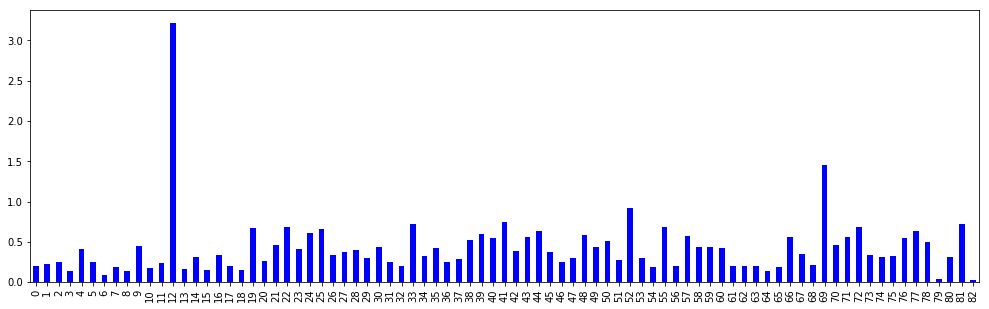

In [20]:
result_df['RMSLE'].plot(kind='bar', figsize=(17,5), color='blue')

In [72]:
print('Mean RMSLE: ',result_df['RMSLE'].mean())
print('Minimum RMSLE: ',result_df['RMSLE'].min())
print('Maximum RMSLE: ',result_df['RMSLE'].max())

Mean RMSLE:  0.42237684267902487
Minimum RMSLE:  0.021910629646582903
Maximum RMSLE:  3.2140194873734815


In [21]:
# Mean RMSLE
result_df['RMSLE'].mean()

0.42237684267902487

In [22]:
# Mean RMSLE after removing two outliers
(result_df['RMSLE'].mean()*83 - 4.7)/81

0.37478120916492674

Mean RMSLE is 0.422, which is approximate 42.23 average percent error accross all the spares.

If we remove two outliers from the plot, then it becomes 37.47%.

While looking at the amount of given data, given time and the complexity of problem is pretty decent.

# 1.3 Feature Importance

In [23]:
mean_fi = []
fi_cols = list(set(list(df1)) - set(['spare', 'repairs']))
for i in range(len(fi_cols)):
    mean_fi.append(feat_imp[fi_cols[i]].mean())

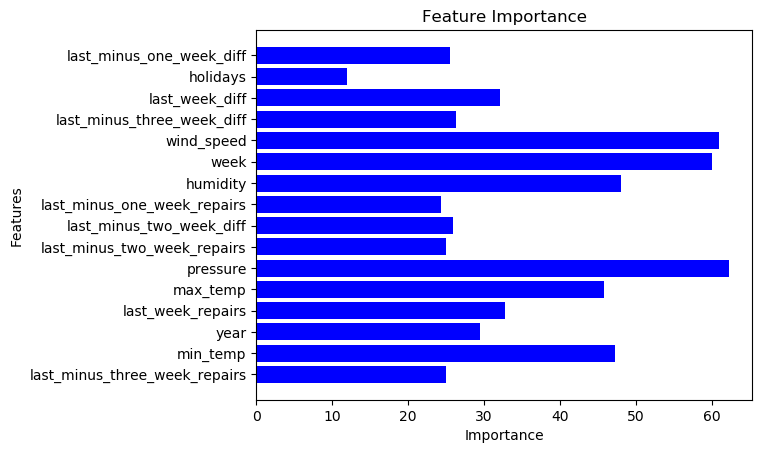

In [26]:
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

features = tuple(fi_cols)
y_pos = np.arange(len(features))
importance = mean_fi

ax.barh(y_pos, importance, align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis() 
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')

plt.show()

It seems that the features Pressure, Week and Wind Speed have affected the results more than other parameters while intrestingly, Holidays have affected less.

# 2.1 Building One Model for All Spares

Here, We have trained one LightGBM model and passed spare part id's as a feature to predict the total weekly repair variable alongwith various other features including weather data, holidays and 4 week lag data.

In [5]:
df2 = df_init.copy()

In [6]:
# converting categorial variables to str type
df2['spare'] = df2['spare'].astype('str')

In [7]:
# encoding categorial columns
from sklearn import preprocessing
cat_cols = ['spare']
for col in cat_cols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df2[col].values.astype('str')))
    df2[col] = lbl.transform(list(df2[col].values.astype('str')))

Here, we have done label encoding as lightGBM have capability to handle categorial variable passed as ordinal values. Still the results may improve by doing one hot key encoding and will do it in later phase.

In [8]:
# creating test df from week 25 to week 36 of 2018 (12 weeks).
# Not including week 37 as it is has incomplete data.
con1 = df2['year']==2018
con2 = df2['week']>24
con3 = df2['week']<37
test_df = df2[con1 & con2 & con3]

In [10]:
# Train Data Frame consists of data from 6th week of 2015 to 24th week of 2018.
# Initial 5 weeks of data was not used as its has null values for 4 week lag data columns.
train_df = df2[415:15106]

Initially we trained all the features present in the data frame, but realized that by using less features (below mentioned) model gives better results. So, here we have show the creation of model with features giving best outcomes.

In [11]:
import lightgbm as lgb
train_x = train_df[['spare', 'week','last_week_repairs','last_week_diff','last_minus_one_week_diff',
                    'last_minus_one_week_repairs']]
train_y = train_df[['repairs']]
test_x = test_df[['spare', 'week','last_week_repairs','last_week_diff','last_minus_one_week_diff',
                  'last_minus_one_week_repairs']]
test_y = test_df[['repairs']]

In [14]:
# Converting dataframe to lightGBM library dataset.
d_train = lgb.Dataset(train_x, label=train_y)

# Setting basic parameters
params = { "objective": "regression", "metric": "rmse"}

# Training the model
lgbmodel = lgb.train(params, d_train, 600)

# Predicting for test df
y_pred_lgbm=lgbmodel.predict(test_x)

# Calculating Accuracy Metrics
rmse, rmsle, mae, evs, R2_score = accuracy_matrices(test_y, y_pred_lgbm)

# Calculating Penalized RMSE
penaliz_rmse, under_predict, over_predict = penalized_rmse(test_y.squeeze().tolist(), y_pred_lgbm.squeeze().tolist())

In [9]:
type2_df = test_df.copy()
type2_df['y_pred'] = y_pred_lgbm
type2_df = type2_df[['spare','week', 'repairs', 'y_pred']]

In [15]:
type2_df['y_pred'] = y_pred_lgbm

In [18]:
type2_df = type2_df[['spare','week', 'repairs', 'y_pred']]

In [19]:
type2_df.to_csv('type2.csv', index=False)

# 2.2 Evaluating the Model

In [44]:
print('rmse:', rmse)
print('rmsle:', rmsle)
print('mae:', mae)
print('explained_variance_score:', evs)
print('r2_score:', R2_score)
print('penalized_rmse: ' , penaliz_rmse)
print('under_predict rows: ', under_predict )
print('over_predict rows: ', over_predict )

rmse: 16.118327476378234
rmsle: 0.4374030956549477
mae: 2.7788076241442448
explained_variance_score: 0.9819689188216303
r2_score: 0.9819191476843562
penalized_rmse:  32.49707805856358
under_predict rows:  438
over_predict rows:  558


# 2.3 Feature Importance

In [45]:
feat_imp = lgbmodel.feature_importance()

In [46]:
feat_names = lgbmodel.feature_name()

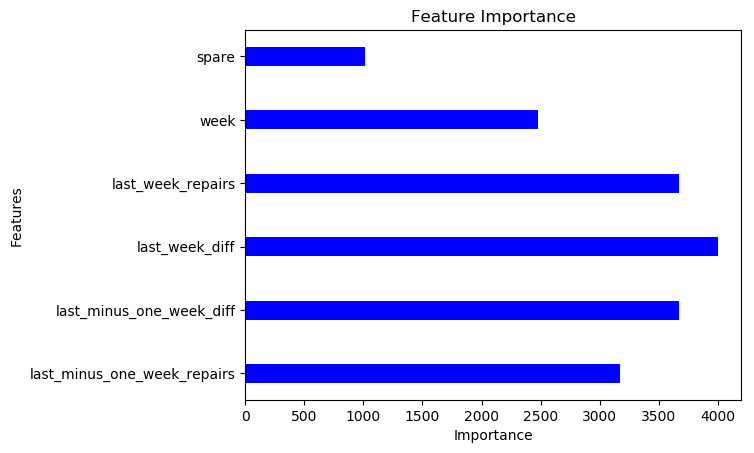

In [66]:
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

features = tuple(feat_names)
y_pos = np.arange(len(features))
importance = list(feat_imp)

ax.barh(y_pos, importance, 0.3,align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')
plt.show()

# Data Wrangling for saving prediction

In [71]:
all_pred[:5]

,spare,week,repairs,y_pred
2,74473,26,31,31.365737
3,74473,27,30,29.657391
4,74473,28,34,31.404603
5,74473,29,43,32.090226
6,74473,30,35,32.383071


In [35]:
final = type2_df[:83]

In [38]:
final['spare'] = all_pred['spare'].unique()

In [58]:
for i in range(25,37):
    col_name1 = 'W' + str(i) + 'T'
    final[col_name1] = 0
    col_name2 = 'W' + str(i) + 'P'
    final[col_name2] = 0.1
final[:5]

,spare,W25T,W25P,W26T,W26P,W27T,W27P,W28T,W28P,W29T,...,W32T,W32P,W33T,W33P,W34T,W34P,W35T,W35P,W36T,W36P
15106,74473,0,0.1,0,0.1,0,0.1,0,0.1,0,...,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1
15107,74476,0,0.1,0,0.1,0,0.1,0,0.1,0,...,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1
15108,74873,0,0.1,0,0.1,0,0.1,0,0.1,0,...,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1
15109,206121,0,0.1,0,0.1,0,0.1,0,0.1,0,...,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1
15110,206145,0,0.1,0,0.1,0,0.1,0,0.1,0,...,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1


In [72]:
abc = pd.read_csv('final_results.csv')

In [75]:
abc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 27 columns):
spare    83 non-null int64
W25T     83 non-null int64
W25P     83 non-null float64
W26T     83 non-null int64
W26P     83 non-null float64
W27T     83 non-null int64
W27P     83 non-null float64
W28T     83 non-null int64
W28P     83 non-null float64
W29T     83 non-null int64
W29P     83 non-null float64
W30T     83 non-null int64
W30P     83 non-null float64
W31T     83 non-null int64
W31P     83 non-null float64
W32T     83 non-null int64
W32P     83 non-null float64
W33T     83 non-null int64
W33P     83 non-null float64
W34T     83 non-null int64
W34P     83 non-null float64
W35T     83 non-null int64
W35P     83 non-null float64
W36T     83 non-null int64
W36P     83 non-null float64
W37P     83 non-null float64
W37T     83 non-null int64
dtypes: float64(13), int64(14)
memory usage: 17.6 KB


In [74]:
abc['W37P'] = 0.1
abc['W37T'] = 0

In [76]:

for index, row in all_pred.iterrows():
    spare = row['spare']
    week = row['week']
    y_pred = row['y_pred']
    repairs = row['repairs']
    col_p = 'W' + str(int(week)) + 'P'
    col_t = 'W' + str(int(week)) + 'T'
    abc[col_p][abc[abc['spare']==spare].index[0]] = y_pred
    abc[col_t][abc[abc['spare']==spare].index[0]] = repairs

In [79]:
abc[:5]

,spare,W26T,W26P,W27T,W27P,W28T,W28P,W29T,W29P,W30T,...,W33T,W33P,W34T,W34P,W35T,W35P,W36T,W36P,W37P,W37T
0,74473,31,31.365737,30,29.657391,34,31.404603,43,32.090226,35,...,23,27.413599,26,34.587108,27,26.481921,24,31.674152,34.655714,10
1,74476,54,60.695535,49,64.794032,43,52.658496,69,54.192319,59,...,33,55.136261,44,47.878906,45,58.991905,47,59.410214,54.269204,22
2,74873,44,29.222366,34,36.149256,44,32.455650,57,30.928627,45,...,41,42.120128,46,36.101866,57,34.143404,36,40.809967,36.468339,10
3,206121,239,234.480056,258,227.567927,254,225.926707,256,236.982809,270,...,168,195.319047,180,192.904117,246,199.949850,259,239.368136,233.931483,84
4,206145,5,7.933852,6,2.519126,11,9.682175,10,6.528351,10,...,3,4.684408,9,2.394573,3,6.138959,8,5.583859,4.919092,5


In [78]:
del abc['W25T']
del abc['W25P']

In [80]:
abc.to_csv('final_results2.csv', index=False)

In [62]:
predicted_df = pd.read_csv('lightGBM_predicted.csv')

In [63]:
predicted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 14 columns):
spare    83 non-null int64
W25P     83 non-null float64
W26P     83 non-null float64
W27P     83 non-null float64
W28P     83 non-null float64
W29P     83 non-null float64
W30P     83 non-null float64
W31P     83 non-null float64
W32P     83 non-null float64
W33P     83 non-null float64
W34P     83 non-null float64
W35P     83 non-null float64
W36P     83 non-null float64
W37P     0 non-null float64
dtypes: float64(13), int64(1)
memory usage: 9.2 KB
